# 4.10 实战Kaggle比赛：预测房价

们实现几个函数来方便下载数据。

首先，我们维护字典DATA_HUB，其将数据集名称的字符串映射到数据集相关的二元组上，这个二元组包含数据集的url和验证文件完整性的sha-1密钥。

所有这样的数据集都托管在地址为DATA_URL的站点上。

## 4.10.1 下载和缓存数据集

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
# download函数用来下载数据集，
# 将数据集缓存在本地目录（默认情况下为../data）中，并返回下载文件的名称。
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
# 两个额外的实用函数：一个是下载并解压缩一个zip或tar文件，
# 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

## 4.10.2 访问和读取数据集

In [4]:
# 如果pandas没有被安装，请取消下一句的注释。
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
# 我们可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
# 使用pandas分别加载包含训练数据和测试数据的两个CSV文件。
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [14]:
# 第一个特征是ID，这有助于模型识别每个训练样本。
# 这很方便，但它不携带任何用于预测的信息。
# 在将数据提供给模型之前，我们将其从数据集中删除。
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features,all_features.shape

(      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0             60       RL         65.0     8450   Pave   NaN      Reg   
 1             20       RL         80.0     9600   Pave   NaN      Reg   
 2             60       RL         68.0    11250   Pave   NaN      IR1   
 3             70       RL         60.0     9550   Pave   NaN      IR1   
 4             60       RL         84.0    14260   Pave   NaN      IR1   
 ...          ...      ...          ...      ...    ...   ...      ...   
 1454         160       RM         21.0     1936   Pave   NaN      Reg   
 1455         160       RM         21.0     1894   Pave   NaN      Reg   
 1456          20       RL        160.0    20000   Pave   NaN      Reg   
 1457          85       RL         62.0    10441   Pave   NaN      Reg   
 1458          60       RL         74.0     9627   Pave   NaN      Reg   
 
      LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
 0            Lvl    AllPub  

In [10]:
# 展示删除ID之后的数据
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml


## 4.10.3 数据预处理
我们标准化数据有两个原因。

首先，它方便优化。

其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

### DataFrame.dtypes
返回DataFrame中的dtypes

In [17]:
# 取出所有的数值型特征名称
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
print(numeric_features)
# 将数值型特征进行 z-score 标准化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有数据都意味着消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
      MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0       0.067320       RL    -0.202033 -0.217841   Pave   NaN      Reg   
1      -0.873466       RL     0.501785 -0.072032   Pave   NaN      Reg   
2       0.067320       RL    -0.061269  0.137173   Pave   NaN      IR1   
3       0.302516       RL    -0.436639 -0.078371   Pave   NaN      IR1   
4       0.067320       RL     0.689469  0.518814   

In [19]:
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
#对无序型进行one-hot encoding
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features,all_features.shape

(      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
 0       0.067320    -0.202033 -0.217841     0.646073    -0.507197   1.046078   
 1      -0.873466     0.501785 -0.072032    -0.063174     2.187904   0.154737   
 2       0.067320    -0.061269  0.137173     0.646073    -0.507197   0.980053   
 3       0.302516    -0.436639 -0.078371     0.646073    -0.507197  -1.859033   
 4       0.067320     0.689469  0.518814     1.355319    -0.507197   0.947040   
 ...          ...          ...       ...          ...          ...        ...   
 1454    2.419286    -2.266564 -1.043758    -1.481667     1.289537  -0.043338   
 1455    2.419286    -2.266564 -1.049083    -1.481667    -0.507197  -0.043338   
 1456   -0.873466     4.255477  1.246594    -0.772420     1.289537  -0.373465   
 1457    0.655311    -0.342796  0.034599    -0.772420    -0.507197   0.682939   
 1458    0.067320     0.220258 -0.068608     0.646073    -0.507197   0.715952   
 
       YearRemodAdd  MasVn

In [20]:
# 通过values属性，我们可以从pandas格式中提取NumPy格式 
# 并将其转换为张量表示用于训练。
# train_data.shape-->1460,81
n_train = train_data.shape[0] # 1460
train_features = torch.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)


## 4.10.4 训练

In [34]:
loss = nn.MSELoss()
in_features = train_features.shape[1] # 81

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net


### torch.clamp(input, min, max, out=None) → Tensor
    | min, if x_i < min
y_i = | x_i, if min <= x_i <= max
     | max, if x_i > max

In [27]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [28]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


## 4.10.5 K折交叉验证

In [29]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [31]:
# 当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [32]:
## 4.10.6 模型选择

fold 1, train log rmse 0.170540, valid log rmse 0.156963
fold 2, train log rmse 0.162395, valid log rmse 0.188692
fold 3, train log rmse 0.164289, valid log rmse 0.168415
fold 4, train log rmse 0.168512, valid log rmse 0.154907
fold 5, train log rmse 0.162704, valid log rmse 0.182995
5-折验证: 平均训练log rmse: 0.165688, 平均验证log rmse: 0.170395


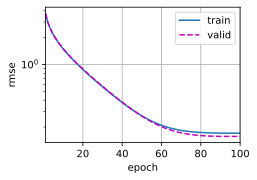

In [35]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 4.10.7 提交预测

In [37]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.163101


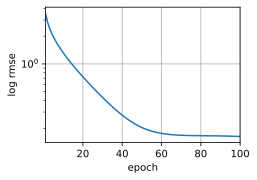

In [38]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)


## 4.10.7 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 将实值数据重新缩放为零均值和单位方差是一个很好的默认设置。用它们的平均值替换缺失的值也是一个很好的默认设置。
* 将类别特征转化为指标特征，可以使我们把它们当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

## 4.10.8 练习

1. 把你的预测提交给Kaggle。你的预测有多好？
1. 你能通过直接最小化价格的对数来改进你的模型吗？如果你试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：你能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？